In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
# import plotly.express as px
import os
from  scipy import ndimage
IMAGES_FOLDER_PATH = "../../img"
import time

In [2]:
def display_img_arr(img_arr, r, c, dim,titles_arr):
    """
    Utility Function to Display Images
    :param img_arr : List of numpy array representing images
    :param r: Number of rows in the subplot
    :param c: Number of coloumns in the subplot
    :param dim: Figure Size of the subplot
    :param titles_arr: Title corresponding to each image in img_arr
    """
    fl = 0
    fig = plt.figure(figsize = dim)
    for i in range(r):
        for j in range(c):
            if len(img_arr) == fl:
                break
            ax1 = fig.add_subplot(r, c, fl + 1)
            ax1.set_title(titles_arr[fl], fontsize = 20)
            ax1.imshow(img_arr[fl], cmap = 'gray')
            fl = fl + 1
    plt.show()
    
def read_img(im_names,path=IMAGES_FOLDER_PATH):
    """
    Utitlity Function to Read Images from file
    :param im_names: Name of the image file in the images folder, directed using the IMAGES_FOLDER_PATH variable
    :return: Two seperate lists containing the colored and grayscale version of images as numpy array 
    """
    im = []
    im_gray = []
    for name in im_names:
        img =  cv2.imread(path+'/'+name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if(len(im)>=1):
            img = cv2.resize(img,(im[0].shape[1],im[0].shape[0]))
        im.append(img)
        im_gray.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    return im, im_gray

In [3]:
# gen trimap (for checking against bad quality trimaps)
img =  cv2.imread(IMAGES_FOLDER_PATH+'/'+'bear_tri.png',0)
# tri = cv2.resize(img,(images[0].shape[0],images[0].shape[1]))
def gen_tri(img,iters):
    """
    generates trimap given a matte or better quality tri-map
    returns trimap 
    """
    kernel = np.ones((5,5),np.uint8)
    tri = cv2.erode(img,kernel,iterations = iters)

    for i in range(tri.shape[0]):
        for j in range(tri.shape[1]):
            if(tri[i][j]!=255 and tri[i][j]!=0):
                tri[i][j] = 127
    return tri

In [4]:
img3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'bear.png'))
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img3_gray = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'bear.png'),0)
tri3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'bear_tri.png'),0)


new_bg3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'jungle_bg.jpeg'))
new_bg3 = cv2.cvtColor(new_bg3, cv2.COLOR_BGR2RGB)
new_bg3 = cv2.resize(new_bg3, (img3.shape[1],img3.shape[0])) 

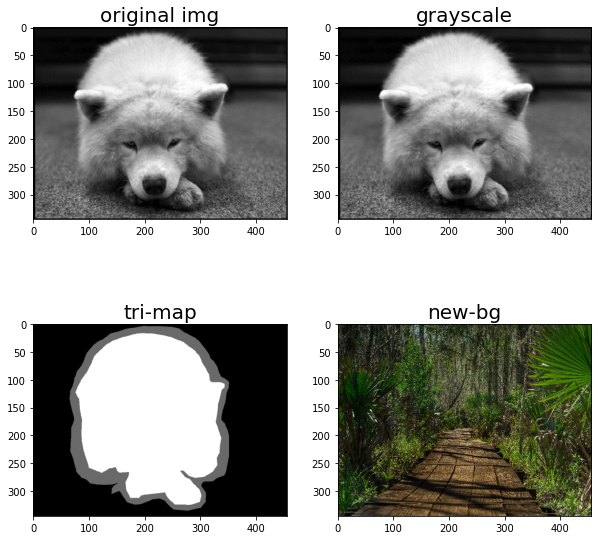

In [5]:
display_img_arr([img3,img3_gray,tri3,new_bg3], 2,2,(10,10), ['original img','grayscale','tri-map','new-bg'])

# Global Matting

Poisson Equation
$$\Delta \alpha = div (\frac{\nabla I}{F-B})$$
where, $\Delta = (\frac{\partial^2}{\partial x^2},\frac{\partial^2}{\partial y^2})$
is Laplacian Operator and div is divergence opertor


We solve this Poisson Equation using Gauss Siedel Iteration with overrealaxation method which is,

Given,  $$ \frac{\partial^2 f}{\partial x^2}+\frac{\partial^2 f}{\partial y^2} = S$$
$$ {f_{i,j}}^{(n+1)} = \frac{\beta}{4}({f_{i+1,j}}^{(n)} + {f_{i-1,j}}^{(n+1)}) + {f_{i,j+1}}^{(n)} + {f_{i,j-1}}^{(n+1)} - S_{i,j}) + (1-\beta){f_{i,j}}^{(n)}$$
where, $\beta$ lies in the range (1,2)



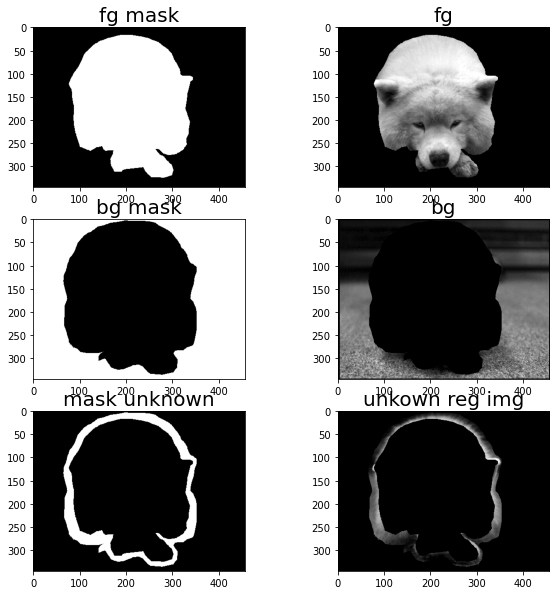

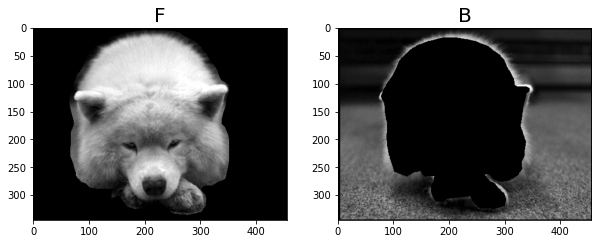

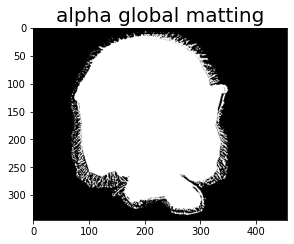

In [6]:
def calc_masks(tri, img_gray):
    """
    Utility Function to Create Masks
    :param tri: A numpy array representing the trimap of the image in Grayscale
    :param img_gray: A numpy array representing the Grayscale version of the image
    :return A list of numpy array representing the foreground mask, foreground image, background mask,
            background image, unknown region mask,unknown region image
    """
    mask_bg = (tri<10)
    mask_fg = (tri>245)
    mask_unknown = (np.bitwise_and(tri>=10,tri<=245))

    fg = img_gray*(mask_fg)
    bg = img_gray*(mask_bg)
    unknown = img_gray*mask_unknown
    return [mask_fg,fg,mask_bg,bg,mask_unknown,unknown], ['fg mask','fg','bg mask','bg','mask unknown','unkown reg img']

def doubleDifferential(img, factor):
    """
    Utility Function to Generate the Double Differential for the Poisson Equation
    :param img: A numpy array representing the Grayscale version of Image
    :param factor: A constant used to divide the first order differential before calculating the second order
                    differential. It can be a constant or a numpy array of the same size as img
    :returns : Two Numpy arrays representing the double differential in Y and X respectively
    """
    dy, dx = np.gradient(img)
    d2y, _ = np.gradient(dy/factor)
    _, d2x = np.gradient(dx/factor)
    return d2y, d2x
    
    
def fb(img_gray,mask_fg,mask_bg,mask_unknown):
    """
    Utility Function to find the Approximate Foreground and Approximate Background using the Trimap provided
    :param img_gray: A numpy array representing the Grayscale version of Image
    :param mask_fg: A numpy array representing the pixels in the Foreground Region
    :param mask_bg: A numpy array representing the pixels in the Background Region
    :param mask_unknown: A numpy array representing the pixels in the Unknown Region
    :returns :Two numpy arrays representing Approximate Foreground and Approximate Background respectively
    """
    F = img_gray*(mask_fg+mask_unknown)
    B = img_gray*(mask_bg+mask_unknown)
    return F, B

def global_alpha_matting(alpha,d2alpha,unknown_seg,iters = 50, threshold = 0.1, beta = 1):
    """
    Implements Global Matting as discussed in the paper. Using image gradients, Approximate Foreground and Approximate 
    Background, it solves the Poisson Equation with the help of Gauss Siedel Approximation
    :param alpha: The Estimated value of Alpha for the Final Matte
    :param d2alpha: Sum of Double Differential in X and Y. Required to solve the Poisson Equation
    :param unknown_seg: A numpy array representing the pixels in the unknown region of the image/trimap
    :param iters: Number of Iterations the Gauss Siedel Approximation wil run
    :param threshold: If the amount of change happening after each iteration is below threshold, the program will end
    :param beta: The Beta Factor involved in Gauss Siedel Approximation
    
    :returns :A numpy array representing Matte produced and time taken to calculate it 
    """
    tic = time.time()
    prev_alpha = np.zeros(alpha.shape)
    diff = np.sum(np.abs(prev_alpha-alpha))
    
    for _ in range(iters):
        diff = np.sum(np.abs(prev_alpha-alpha))
        if diff < threshold:
            break
        for i in range(1,alpha.shape[0]-1):
            for j in range(1,alpha.shape[1]-1):
                if unknown_seg[i,j]!=0 :
                    alpha[i,j] = ((beta*(alpha[i,j-1]+alpha[i-1,j]+prev_alpha[i,j+1]+prev_alpha[i+1,j] - d2alpha[i,j])/4) + (1-beta)*prev_alpha[i,j])
    tac = time.time()                    
    return alpha, tac-tic

def grads(F,B,mask_fg,img_gray,mask_unknown):
    """
    Finding the Gradient and Difference required for the Poisson Equation and 
    the Estimate Alpha for Global Mating
    :param F: A numpy array representing Approximate Foreground 
    :param B: A numpy array representing Approximate Background 
    :param mask_fg: A numpy array representing the pixels in the Foreground Region
    :param img_gray: A numpy array representing the Grayscale version of Image
    :param mask_unknown: A numpy array representing the pixels in the Unknown Region
   
    :returns :A numpy array representing the estimate alpha, A numpy array representing Double Differential
               A numpy array representing the difference of Approximate Foreground and Background
    """
    diff = np.minimum(np.maximum(F-B,0),255)

    diff = ndimage.filters.gaussian_filter(diff, 0.9)
    diff = np.minimum(np.maximum(diff,0),255)
    grad_y,grad_x = np.gradient(img_gray)
    diff[diff==0] = 1
    d2y_alpha, _ = np.gradient(grad_y/diff)
    _, d2x_alpha = np.gradient(grad_x/diff)
    d2alpha = d2y_alpha + d2x_alpha
    estimate_alpha = mask_fg + 0.5*mask_unknown
    return estimate_alpha, d2alpha, diff

def func_estimate_alpha(tri, img_gray):
    """
    Main Function to calculate the estimate alpha
    :params tri: trimap
    :params img_gray: gray input image
    :returns estimated alpha
    """
    imgs, titles = calc_masks(tri, img_gray)
    display_img_arr(imgs, 3,2,(10,10),titles)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
    
    F,B = fb(img_gray,mask_fg,mask_bg,mask_unknown)
    display_img_arr([F,B], 1,2,(10,10),['F','B'])
#     print(mask_fg.shape,fg.shape,mask_bg.shape,bg.shape,mask_unknown.shape,unknown.shape,F.shape,B.shape,img_gray.shape)
    est_alpha, d2alpha, diff =  grads(F,B,mask_fg,img_gray,mask_unknown)
    return est_alpha, F, B, d2alpha, imgs, diff

def matting_combined(tri, img_gray):
    """
    Main Function to calculate the Matte
    :params tri: trimap
    :params img_gray: gray input image
    returns all images dict used for matting: {'alpha': alpha, 'F':F, 'B': B, 'diff': diff, 'unknown': unknown, 'mask_unknown': mask_unknown}
    """
    estimate_alpha, F, B, d2alpha, imgs, diff = func_estimate_alpha(tri, img_gray)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
    alpha, _ = global_alpha_matting(estimate_alpha,d2alpha,mask_unknown)
    alpha = np.minimum(np.maximum(alpha,0),1)

    return {'alpha': alpha, 'F':F, 'B': B, 'diff': diff, 'unknown': unknown, 'mask_unknown': mask_unknown}

#     return alpha
# alpha = matting_combined(tri3, img3_gray)
all_data = matting_combined(tri3, img3_gray)
## adding images also to this all_data
all_data.update({'img3': img3, 'img3_gray': img3_gray})

## NOW all_data VARIABLE CONTAINS IMG3, IMG3_GRAY, ALPHA, DIFF, F, B, UNKNOWN


# display_img_arr([new_img ], 1,1,(10,10),['img with new bg'])

display_img_arr([all_data['alpha']], 1,2,(10,10),['alpha global matting'])


# Alpha blending

### I = α F + (1 − α )B

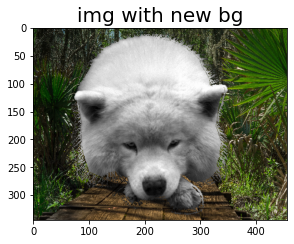

In [7]:
def alpha_blend(new_bg,alpha,img):
    """
    Utility Function to Calculate the Image on a New Background using the Matte produced by anyone of the methods
    :param new_bg: A numpy array representing the New Background (Coloured)
    :param alpha: A numpy array representing the matte produced
    :param img: Original Image containing the foreground
    """
    new_img = np.zeros(new_bg.shape)
    new_img[:,:,0] = alpha*img[:,:,0] + (1-alpha)*new_bg[:,:,0]
    new_img[:,:,1] = alpha*img[:,:,1] + (1-alpha)*new_bg[:,:,1]
    new_img[:,:,2] = alpha*img[:,:,2] + (1-alpha)*new_bg[:,:,2]
    return np.int64(new_img)

new_img = alpha_blend(new_bg3,all_data['alpha'],img3)
display_img_arr([new_img ], 1,2,(10,10),['img with new bg'])

## Local Matting

In [8]:
# get ROI from Select_roi.py

!python3 Select_roi.py ../../img/bear.png
#returns top, left, bottom, right
# Select region where matte to be improved, after selecting type "quit"
#coords selected are saved in coords.txt file

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
QObject::moveToThread: Current thread (0x557193e6e1c0) is not the object's thread (0x557194343150).
Cannot move to target thread (0x557193e6e1c0)

QObject::moveToThread: Current thread (0x557193e6e1c0) is not the object's thread (0x557194343150).
Cannot move to target thread (0x557193e6e1c0)

QObject::moveToThread: Current thread (0x557193e6e1c0) is not the object's thread (0x557194343150).
Cannot move to target thread (0x557193e6e1c0)

QObject::moveToThread: Current thread (0x557193e6e1c0) is not the object's thread (0x557194343150).
Cannot move to target thread (0x557193e6e1c0)

QObject::moveToThread: Current thread (0x557193e6e1c0) is not the object's thread (0x557194343150).
Cannot move to target thread (0x557193e6e1c0)

QObject::moveToThread: Current thread (0x557193e6e1c0) is not the object's thread (0x557194343150).
Cannot move to target thread (0x557193e6e1c0)

QObject::moveToT

QObject::moveToThread: Current thread (0x557193e6e1c0) is not the object's thread (0x557194343150).
Cannot move to target thread (0x557193e6e1c0)

QObject::moveToThread: Current thread (0x557193e6e1c0) is not the object's thread (0x557194343150).
Cannot move to target thread (0x557193e6e1c0)

(90, 2, 247, 38)


In [9]:
def read_coords():
    f = open('coords.txt','r')
    coords = f.read()
    f.close()
    # converting to int
    coord_int = []
    coords_i = coords.split(' ')
    for c in coords_i:
        if(c!=''):
            coord_int.append(int(c))
    return coord_int
coords =  read_coords() 
print(coords)
left, top,add_right, add_bottom = coords
right = left + add_right
bottom = top + add_bottom
print(top, bottom, left, right)

[90, 2, 247, 38]
2 40 90 337


## Diffusion Filtering

In [10]:
# !pip install medpy

In [11]:
from medpy.filter.smoothing import anisotropic_diffusion



![diffusion_params.png](../img/diffusion_params.png) 

/home/avani/.local/lib/python3.8/site-packages/medpy/filter/smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/home/avani/.local/lib/python3.8/site-packages/medpy/filter/smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


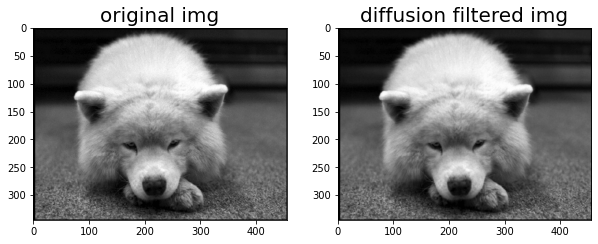

In [12]:
def diffusion(img):
    """
    args: img
    returns new img which is to be passed in for further refinement
    """
    diffused_image = anisotropic_diffusion(img3, niter=1, kappa=50, gamma=0.1, voxelspacing=None, option=1)
    ans = np.round(diffused_image)

    final_ans = np.empty(img3.shape, dtype=int)
    for k in range(3):
        for i in range(ans.shape[0]):
            for j in range(ans.shape[1]):
                final_ans[i, j, k] = int(ans[i, j, k])
    return final_ans
img3_gray = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'bear.jpeg'),0)
new_img3 = diffusion(img3)
display_img_arr([img3,new_img3], 1,2,(10,10),['original img','diffusion filtered img'])


Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
QObject::moveToThread: Current thread (0x55bdbfe0d1c0) is not the object's thread (0x55bdc01edec0).
Cannot move to target thread (0x55bdbfe0d1c0)

QObject::moveToThread: Current thread (0x55bdbfe0d1c0) is not the object's thread (0x55bdc01edec0).
Cannot move to target thread (0x55bdbfe0d1c0)

QObject::moveToThread: Current thread (0x55bdbfe0d1c0) is not the object's thread (0x55bdc01edec0).
Cannot move to target thread (0x55bdbfe0d1c0)

QObject::moveToThread: Current thread (0x55bdbfe0d1c0) is not the object's thread (0x55bdc01edec0).
Cannot move to target thread (0x55bdbfe0d1c0)

QObject::moveToThread: Current thread (0x55bdbfe0d1c0) is not the object's thread (0x55bdc01edec0).
Cannot move to target thread (0x55bdbfe0d1c0)

QObject::moveToThread: Current thread (0x55bdbfe0d1c0) is not the object's thread (0x55bdc01edec0).
Cannot move to target thread (0x55bdbfe0d1c0)

QObject::moveToT

QObject::moveToThread: Current thread (0x55bdbfe0d1c0) is not the object's thread (0x55bdc01edec0).
Cannot move to target thread (0x55bdbfe0d1c0)

QObject::moveToThread: Current thread (0x55bdbfe0d1c0) is not the object's thread (0x55bdc01edec0).
Cannot move to target thread (0x55bdbfe0d1c0)

(269, 14, 187, 251)
14 265 269 456
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
QObject::moveToThread: Current thread (0x5586a2ca31c0) is not the object's thread (0x5586a3158f70).
Cannot move to target thread (0x5586a2ca31c0)

QObject::moveToThread: Current thread (0x5586a2ca31c0) is not the object's thread (0x5586a3158f70).
Cannot move to target thread (0x5586a2ca31c0)

QObject::moveToThread: Current thread (0x5586a2ca31c0) is not the object's thread (0x5586a3158f70).
Cannot move to target thread (0x5586a2ca31c0)

QObject::moveToThread: Current thread (0x5586a2ca31c0) is not the object's thread (0x5586a3158f70).
Cannot move to target thread

(12, 22, 136, 272)
22 294 12 148
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
QObject::moveToThread: Current thread (0x55911464a1c0) is not the object's thread (0x559114a2aec0).
Cannot move to target thread (0x55911464a1c0)

QObject::moveToThread: Current thread (0x55911464a1c0) is not the object's thread (0x559114a2aec0).
Cannot move to target thread (0x55911464a1c0)

QObject::moveToThread: Current thread (0x55911464a1c0) is not the object's thread (0x559114a2aec0).
Cannot move to target thread (0x55911464a1c0)

QObject::moveToThread: Current thread (0x55911464a1c0) is not the object's thread (0x559114a2aec0).
Cannot move to target thread (0x55911464a1c0)

QObject::moveToThread: Current thread (0x55911464a1c0) is not the object's thread (0x559114a2aec0).
Cannot move to target thread (0x55911464a1c0)

QObject::moveToThread: Current thread (0x55911464a1c0) is not the object's thread (0x559114a2aec0).
Cannot move to target thread (

(116, 298, 220, 47)
298 345 116 336


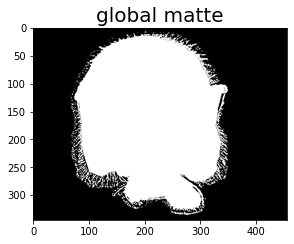

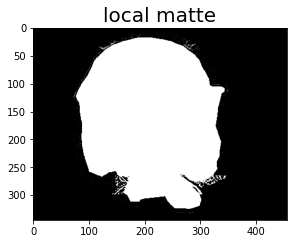

In [13]:
def local_matting(data_dic, top, bottom, left, right):
    """
    Local Matting functions which uses the Matte supplied by Global Matting and 
    Co-ordinates supplied by User to improve the Matte.
    :param data_dic: A dictionary containing the various images calculated while performing global matting
    :param top: A value representing the Horizontal Line of the Top Side of ROI
    :param bottom: A value representing the Horizontal Line of the Bottom Side of ROI
    :param left: A value representing the Vertical Line of the Left Side of ROI
    :param right: A value representing the Vertical Line of the Right Side of ROI
    """
    h, w = data_dic['alpha'].shape[0], data_dic['alpha'].shape[1]
    local = 0
    if('local_matte' in data_dic.keys()):
        local = 1
        h, w = data_dic['local_matte'].shape[0], data_dic['local_matte'].shape[1]
        
    
    new_diff = data_dic['diff'][top:bottom+1, left:right+1]
    
    ## APPLYING GAUSSIAN FILTER ON THIS NEW DIFF
    new_diff = ndimage.filters.gaussian_filter(new_diff, 0.9)
    new_diff = np.minimum(np.maximum(new_diff,0),255)
    
    ## EXTRACTING SEGMENTS IN GIVEN RANGE FOR ORIGINAL IMAGE, FOREGROUND AND THE BACKGROUND
    required_img= data_dic['img3_gray'].copy()[top:bottom+1, left:right+1]
    required_fg = data_dic['F'].copy()[top:bottom+1,left:right+1]
    required_bg = data_dic['B'].copy()[top:bottom+1,left:right+1]
    required_unknown = data_dic['unknown'].copy()[top:bottom,left:right]
    required_alpha= data_dic['alpha'].copy()[top:bottom+1,left:right+1]
    if(local==1):
        required_alpha= data_dic['local_matte'].copy()[top:bottom+1,left:right+1]
    
    required_inverted_alpha= 1 - required_alpha
    required_mask_unknown = data_dic['mask_unknown'].copy()[top:bottom+1, left:right+1]
    
    
    ## GET DOUBLE DIFFERENTIAL FOR IMG, FOREGROUND AND BACKGROUND
    fg_d2y, fg_d2x = doubleDifferential(required_fg, new_diff)
    bg_d2y, bg_d2x = doubleDifferential(required_bg, new_diff)
    img_d2y, img_d2x = doubleDifferential(required_img, new_diff)
    weighted_fg = required_alpha*(fg_d2x+fg_d2y)
    weighted_bg = required_alpha*(bg_d2x+bg_d2y)
    new_d2alpha = img_d2x + img_d2y - weighted_fg - weighted_bg
    

#     display_img_arr([data_dic['alpha']], 1,2,(10,10),['alpha'])
    matte, time = global_alpha_matting(required_alpha,new_d2alpha,required_mask_unknown, iters= 50, threshold = 0.1, beta = 0.2)
#     display_img_arr([data_dic['alpha'],data_dic['mask_unknown']], 1,2,(10,10),['alpha','mask unkwon'])
    matte = np.minimum(np.maximum(matte,0),1)
    
    
#     matte, _= optimal_alpha_matting(required_alpha, new_d2alpha, required_unknown)

    return matte
all_data_2 = all_data.copy()
local_matte =  all_data_2['alpha'].copy()
# print(local_matte.shape)

# # selecting regions which we feel are not correct in matte


local_matte[top:bottom+1, left:right+1] = local_matting(all_data_2.copy(), top, bottom, left, right)
all_data_2['local_matte'] = local_matte
iters = 3
for i in range(iters):
    !python3 Select_roi.py ../../img/bear.png
    coords =  read_coords() 
    left, top,add_right, add_bottom = coords
    right = left + add_right
    bottom = top + add_bottom
    print(top, bottom, left, right)

    local_matte[top:bottom+1, left:right+1] = local_matting(all_data_2.copy(), top, bottom, left, right)
    all_data_2['local_matte'] = local_matte

display_img_arr([all_data['alpha']], 1,2,(10,10),['global matte'])

# top,bottom,left,right = [400,420,90,110]
# local_matte[top:bottom+1, left:right+1] = local_matting(all_data_2.copy(), top, bottom, left, right)
# top, bottom, left, right = [280, 400, 80, 100]
# data_dic['alpha'] = local_matte
# local_matte[top:bottom+1, left:right+1] = local_matting(data_dic, top, bottom, left, right)
    
# local_matte = np.minimum(np.maximum(local_matte,0),1)
display_img_arr([local_matte], 1,2,(10,10),['local matte'])

### Local Poisson Matting vs Global Matting 

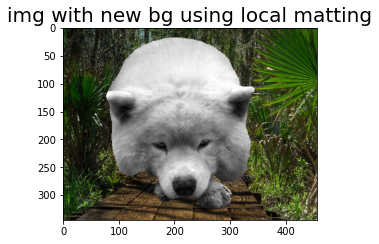

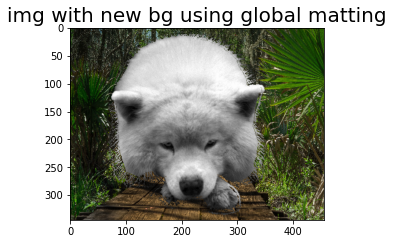

In [14]:
new_img_local = alpha_blend(new_bg3,local_matte,img3)
display_img_arr([new_img_local], 1,2,(10,10),['img with new bg using local matting'])
display_img_arr([new_img], 1,2,(10,10),['img with new bg using global matting'])


## Combining  multiple bg's

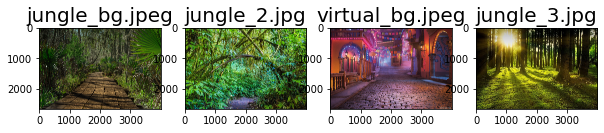

In [15]:
bg_names = ['jungle_bg.jpeg','jungle_2.jpg','virtual_bg.jpeg','jungle_3.jpg']
bgs,bgs_g = read_img(bg_names)
display_img_arr(bgs, 1,4,(10,10),bg_names)

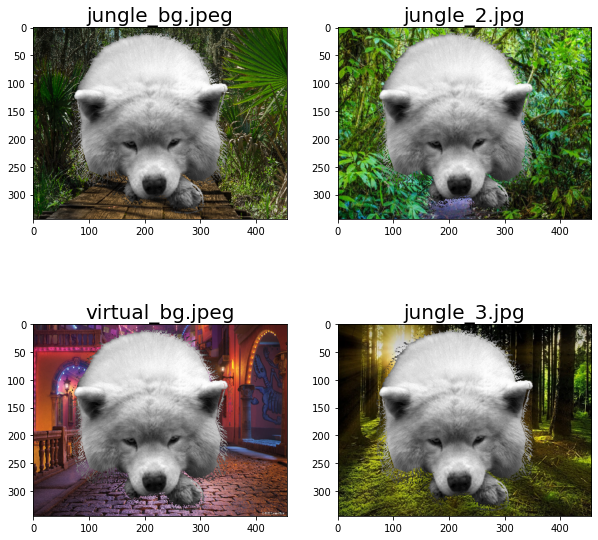

In [16]:
# generate image in new bgs
new_imgs = []
for bg in bgs:
    bg = cv2.resize(bg, (img3.shape[1],img3.shape[0]))
    new_imgs.append(alpha_blend(bg,all_data['alpha'],img3 ))
    

display_img_arr(new_imgs, 2,2,(10,10),bg_names)    

# Refinement

### Local high pass

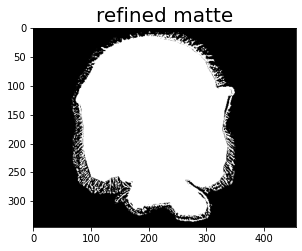

In [17]:

import scipy
def high_pass(all_data,top, bottom, left, right):
    """
     Utility: Finds the approximate D on local regions: regions selected by user for refinement
    :param all_data: A dictionary containing the various images calculated while performing global matting
    :param top: A value representing the Horizontal Line of the Top Side of ROI
    :param bottom: A value representing the Horizontal Line of the Bottom Side of ROI
    :param left: A value representing the Vertical Line of the Left Side of ROI
    :param right: A value representing the Vertical Line of the Right Side of ROI
    returns a refined matte from high pass
    """
    h = all_data['alpha'].copy().shape[0]
    w =  all_data['alpha'].copy().shape[1]
    alpha_matte = all_data['alpha'].copy()
    refine_matte = np.zeros((h,w))
    diff_2 = all_data['diff'].copy()[top:bottom+1,left:right+1]
    diff_2 = scipy.ndimage.filters.gaussian_filter(diff_2, 0.9)
    
    segmented_fg = all_data['F'].copy()[top:bottom+1,left:right+1]
    dyfg, dxfg = np.gradient(segmented_fg)
    yfg_n = dyfg/diff_2
    d2yfg, _ = np.gradient(yfg_n)
    xfg_n = dxfg/diff_2
    _, d2xfg = np.gradient(xfg_n)
    
    segmented_bg = all_data['B'].copy()[top:bottom+1,left:right+1]
    dybg, dxbg = np.gradient(segmented_bg)
    ybg_n = dybg/diff_2
    d2ybg, _ = np.gradient(ybg_n)
    xbg_n = dxbg/diff_2
    _, d2xbg = np.gradient(xbg_n)
    
    seg = all_data['img3_gray'].copy()[top:bottom+1,left:right+1]
    refined_D = cv2.GaussianBlur(seg,(3,3),0)
    dy, dx = np.gradient(seg)
    dy_normalized = dy/diff_2
    d2y, _ = np.gradient(dy_normalized)
    x_normalized = dx/diff_2
    _, d2x = np.gradient(x_normalized)
    segmented_bg = d2y + d2x - refined_D
 
    
    Estimate_alpha_seg = all_data['alpha'].copy()[top:bottom+1,left:right+1]
    D = (Estimate_alpha_seg*(d2yfg + d2xfg) + (1 - Estimate_alpha_seg)*(d2ybg+d2xbg))
    
    matte,_ = global_alpha_matting(Estimate_alpha_seg, segmented_bg,all_data['unknown'].copy()[top:bottom,left:right])
    
    return matte


def boosting(all_data,top, bottom, left, right):
    """
     Utility: manipulates A on local regions: regions selected by user for refinement, smoorthens or sharpens depending on value of lambda
    :param all_data: A dictionary containing the various images calculated while performing global matting
    :param top: A value representing the Horizontal Line of the Top Side of ROI
    :param bottom: A value representing the Horizontal Line of the Bottom Side of ROI
    :param left: A value representing the Vertical Line of the Left Side of ROI
    :param right: A value representing the Vertical Line of the Right Side of ROI
    : param lambda_ : If lambda > 0, this filter will increase A else decrease A around brush center
    returns a refined matte from high pass
    """
    
    h, w = all_data['alpha'].copy().shape[0], all_data['alpha'].copy().shape[1]
    alpha_matte = all_data['alpha'].copy()
    refine_matte = np.zeros((h,w))
    diff_2 = all_data['diff'].copy()[top:bottom+1,left:right+1]
    diff_2 = scipy.ndimage.filters.gaussian_filter(diff_2, 0.9)

    lambda_ = 5
    sigma = 20
    seg = all_data['img3_gray'].copy()[top:bottom+1,left:right+1]
    dy, dx = np.gradient(seg)
    dy_normalised = dy/diff_2
    d2y, _ = np.gradient(dy_normalised)
    dx_normalised = dx/diff_2
    _, d2x = np.gradient(dx_normalised)

    
    segmented_fg = all_data['F'].copy()[top:bottom+1,left:right+1]
    dyfg, dxfg = np.gradient(segmented_fg)
    yfg_n = dyfg/diff_2
    d2yfg, _ = np.gradient(yfg_n)
    xfg_n = dxfg/diff_2
    _, d2xfg = np.gradient(xfg_n)

    segmented_bg = all_data['B'].copy()[top:bottom+1,left:right+1]
    dybg, dxbg = np.gradient(segmented_bg)
    ybg_n = dybg/diff_2
    d2ybg, _ = np.gradient(ybg_n)
    xbg_n = dxbg/diff_2
    _, d2xbg = np.gradient(xbg_n)

    A = np.zeros((h,w))
    
    x0 = top + bottom - top +1/2
    y0 = left + right-left +1/2
    for x in range(top,bottom+1+1):
        for y in range(left,right+1+1):
            A[x,y] = (1 + lambda_*np.exp(-1*((abs(x-x0)**2+(abs(y-y0))**2))/(2*sigma**2)))*(1/all_data['diff'].copy()[x,y])
    diff_2 = 1/A[top:bottom+1,left:right+1]
    
    Estimate_alpha_seg = alpha_matte[top:bottom+1,left:right+1]
    
    D = (Estimate_alpha_seg*(d2yfg + d2xfg) + (1 - Estimate_alpha_seg)*(d2ybg+d2xbg))
    
    segmented_bg = d2y + d2x - D
    matte1,_ = global_alpha_matting(Estimate_alpha_seg, segmented_bg,all_data['unknown'].copy()[top:bottom,left:right])
    
    return matte1

'''
Performing Local Filter Operations on user selected regions and Obtaining the refined alpha Matte
'''

# selecting regions which we feel are not correct in matte
al_data_2 = all_data.copy()

refine_matte = all_data_2['alpha'].copy()


top, bottom, left, right = [130,150,280,310]
all_data_2['refine_matte'] = refine_matte
refine_matte[top:bottom+1,left:right+1] = boosting(all_data_2.copy(),top, bottom, left, right)


# top, bottom, left, right = [300,330,0,90]
# all_data_2['refine_matte'] = refine_matte
# refine_matte[top:bottom+1,left:right+1] = boosting(all_data_2.copy(),top, bottom, left, right)

# # top, bottom, left, right = [350,400,100,150]
# # all_data_2['refine_matte'] = refine_matte
# # refine_matte[top:bottom+1,left:right+1] = boosting(all_data_2.copy(),top, bottom, left, right)

# top, bottom, left, right = [350,476,380,440]
# all_data_2['refine_matte'] = refine_matte
# refine_matte[top:bottom+1,left:right+1] = boosting(all_data_2.copy(),top, bottom, left, right)


# top, bottom, left, right = [0,8,210,430]
# all_data_2['refine_matte'] = refine_matte
# refine_matte[top:bottom+1,left:right+1] = boosting(all_data_2.copy(),top, bottom, left, right)

# top, bottom, left, right = [330,476,100,170]
# all_data_2['refine_matte'] = refine_matte
# refine_matte[top:bottom+1,left:right+1] = boosting(all_data_2.copy(),top, bottom, left, right)

refine_matte = np.maximum(refine_matte,0)
refine_matte = np.minimum(refine_matte,1)

h, w = all_data_2['alpha'].shape[0], all_data_2['alpha'].shape[1]
refine_matte = refine_matte.reshape(h,w)
display_img_arr([refine_matte], 1,3,(16,40), ['refined matte'])

In [18]:
refine_matte.shape, img3.shape

((345, 456), (345, 456, 3))

refined matting results


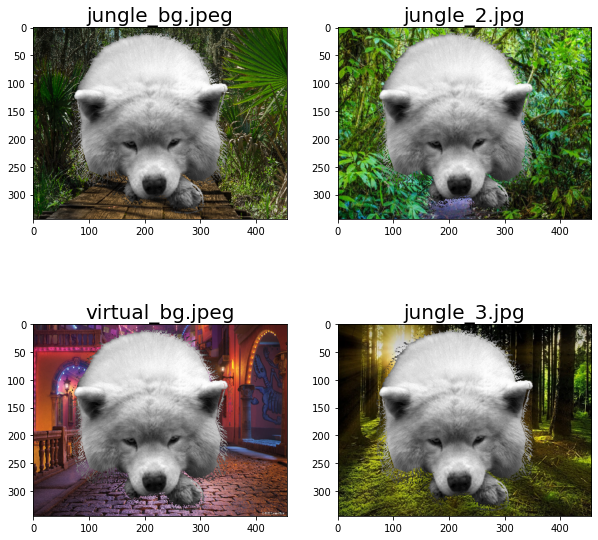

In [19]:
# generate image in new bgs
img3 = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, 'bear.png'))
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
new_imgs_refined = []
for bg in bgs:
    bg = cv2.resize(bg, (img3.shape[1],img3.shape[0]))
    new_imgs_refined.append(alpha_blend(bg,refine_matte,img3 ))
    
print('refined matting results')
display_img_arr(new_imgs_refined, 2,2,(10,10),bg_names)  

In [20]:
# saving imgages
out_path = '../../outs'
for i,im in enumerate(new_imgs_refined):
    plt.imsave(out_path+'/'+'bear_refined'+str(i)+'.png',im.astype('uint8'))

global matting results


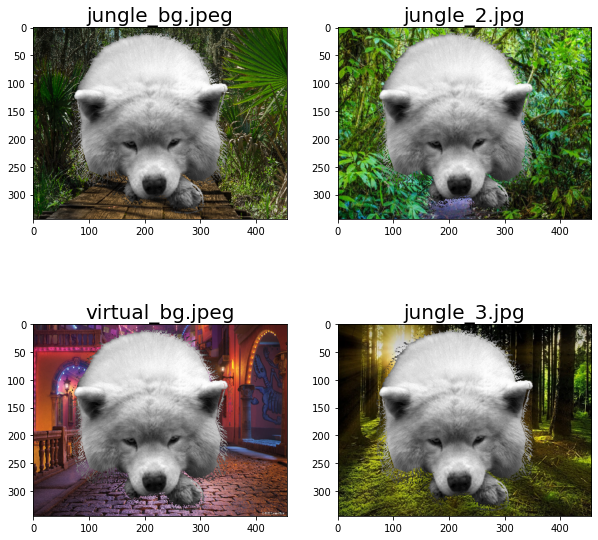

In [21]:
# generate image in new bgs
new_imgs = []
for bg in bgs:
    bg = cv2.resize(bg, (img3.shape[1],img3.shape[0]))
    new_imgs.append(alpha_blend(bg,all_data['alpha'],img3 ))
    
print('global matting results')
display_img_arr(new_imgs, 2,2,(10,10),bg_names)  

Clearly it is seen that refinement improves the matte to great extent

## Channel Selection


In [22]:
from scipy.optimize import fmin

def funct(params,img):
    channel_0_mean = np.mean(img[:,:,0])
    channel_1_mean = np.mean(img[:,:,1])
    channel_2_mean = np.mean(img[:,:,2])
    
    loss = np.linalg.norm((img[:,:,0]-channel_0_mean)*params[0] + (img[:,:,1]-channel_1_mean)*params[1] + (img[:,:,2]-channel_2_mean)*params[2])
    
    return loss


# !python3 Select_roi.py ../../img/img4.png
coords =  read_coords() 
print(coords)
left, top,add_right, add_bottom = coords
right = left + add_right
bottom = top + add_bottom
print(top, bottom, left, right)
new_img  = np.zeros((img3.shape))
new_img[top:bottom+1,left:right+1] = img3[top:bottom+1,left:right+1]

final_params = fmin(funct, np.array([0.2,0.4,0.4]),args=(new_img,))
final_params = final_params/np.sum(final_params)
a,b,c = final_params


[116, 298, 220, 47]
298 345 116 336
Optimization terminated successfully.
         Current function value: 0.000098
         Iterations: 83
         Function evaluations: 164


## Multi- background



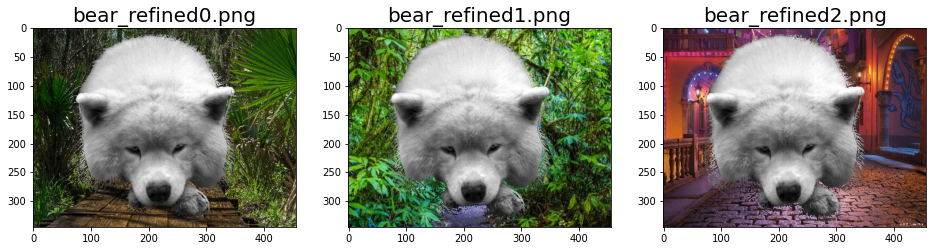

In [23]:
names = ['bear_refined0.png','bear_refined1.png','bear_refined2.png']
images,im_gray = read_img(names,'../../outs')
display_img_arr(images, 1,3,(16,40), names)

In [24]:
# def resize_im(images):
#     new_imgs = []
#     for i in images:
#         new_imgs.append(cv2.resize(i,(images[0].shape[0],images[0].shape[1])))
#     return new_imgs
# im_gray = resize_im(im_gray)
# images = resize_im(images)
for i in im_gray:
    print(i.shape)
for i in images:
    print(i.shape)  

(345, 456)
(345, 456)
(345, 456)
(345, 456, 3)
(345, 456, 3)
(345, 456, 3)


In [25]:
img =  cv2.imread(IMAGES_FOLDER_PATH+'/'+'bear_tri.png',0)
tri = cv2.resize(img,(images[0].shape[1],images[0].shape[0]))
print(tri.shape)

(345, 456)


In [26]:
# with multi-bg
T = 3
def calc_mean_img(T,alpha, B_arr,F):
    """
    :param T number of images
    :param alpha estimated matte of one image
    :param B_arr array containing Approximate Backgrounds of all T images
    :param F A numpy array representing Approximate Foreground 
     returns: mean image
    """
    B_mean = np.zeros((B_arr[0].shape)).astype('float64')
    for i in range(T):
        B_mean += B_arr[i]
        display_img_arr([B_arr[i]], 1,2,(10,10),['B'+str(i+1)])
    B_mean /= T
    B_mean = B_mean.astype(np.uint8)
    
    mean_img = alpha*F+(np.ones((B_arr[0].shape))-alpha)*B_mean
    
    display_img_arr([F,B_mean,mean_img], 3,2,(10,10),['F','B_mean','mean img'] )
    return mean_img


def func_estimate_alpha(tri3, img3_gray,images):
    """
    Main Function to calculate the estimate alpha
    :params tri: trimap
    :params img_gray: gray input image
    :params images:  array containing all input gray images
    """
    imgs, titles = calc_masks(tri3, img3_gray)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
    
    F,B = fb(img3_gray,mask_fg,mask_bg,mask_unknown)
    B_arr = [B]
    for i in range(1,T):
        _,B = fb(images[i],mask_fg,mask_bg,mask_unknown)
        B_arr.append(B)      
    est_alpha,d2alpha,diff=  grads(F,B,mask_fg,img3_gray,mask_unknown)
    return est_alpha, F, B, B_arr,diff, d2alpha, imgs
    

def matting_combined(tri3, img3_gray,images):
    """
    Main Function to calculate the Matte
    :params tri: trimap
    :params img_gray: gray input image
    :params images:  array containing all input gray images
    returns all images dict used for matting: {'alpha': alpha, 'F':F, 'B': B, 'B_arr':B_arr,'diff': diff, 'unknown': unknown, 'mask_unknown': mask_unknown}
    """
    estimate_alpha, F, B,B_arr, diff, d2alpha,imgs = func_estimate_alpha(tri3, img3_gray,images)
    mask_fg,fg,mask_bg,bg,mask_unknown,unknown = imgs
    
    alpha, _ = global_alpha_matting(estimate_alpha,d2alpha,mask_unknown, iters= 100, threshold = 0.01, beta = 1.2)
    alpha = np.minimum(np.maximum(alpha,0),1)
#     return alpha, d2alpha, B_arr
    return {'alpha': alpha, 'F':F, 'B': B, 'B_arr':B_arr, 'diff': diff, 'unknown': unknown, 'mask_unknown': mask_unknown,'img3_gray':img3_gray}



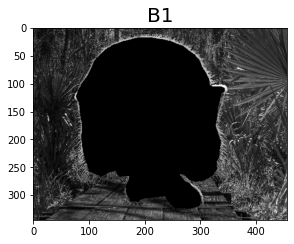

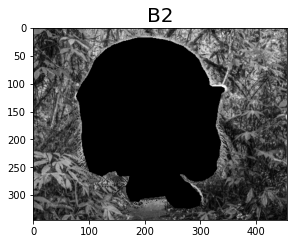

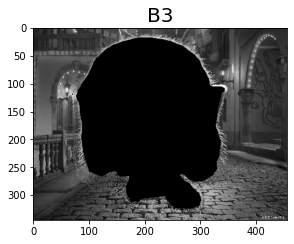

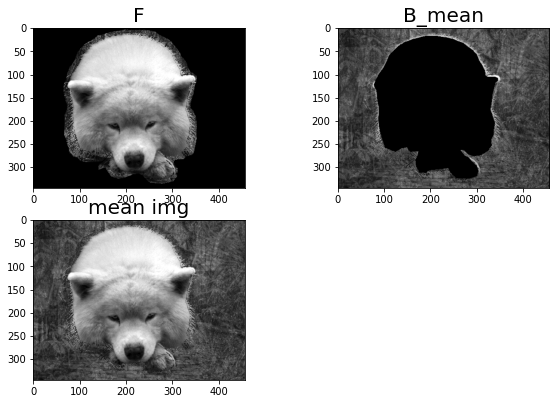

In [27]:

def mean_bg(tri,images):
    """
    Calculate mean bg matte
    :params tri: trimap
    :params images:  array containing all input gray images
    returns mean bg matte and mean image
    """
    
    alpha_est,F,B,B_arr,diff,d2alpha,imgs = func_estimate_alpha(tri, images[0],images)
#     alpha,d2_alpha, _ = matting_combined(tri, images[0],images)
    mean_img = calc_mean_img(3,alpha_est,B_arr ,F)
    all_data = matting_combined(tri, mean_img,images)
    return  mean_img, all_data

mean_img, all_data2 = mean_bg(tri,im_gray)
